### Solution to Project 1 - Finding Lanes on the road

This solution utilises a number of Computer Vision techniques in order to detect road markings using the OpenCV library. The output is demonstrated first on static images captured while driving in various scenarios and using a computation pipeline composed of:
1. Reading the raw image into a computable array format (based on RGB encodings)
2. Region masking the images to select only the area of interest
3. Detecting lines using the OpenCV canny edge detection and after applying a custom Gaussian smoothing factor and greyscale 
4. Applying a Hough transform to the edge detected image to select only the lane lines
5. Highligting the lane lines in the image and extrapolating them to the edge of the area of interest

<BR><BR>




#### Step 1 - Loading the images into numerical format

Image solidWhiteCurve.jpg captured in array with dimensions:(540, 960, 3)


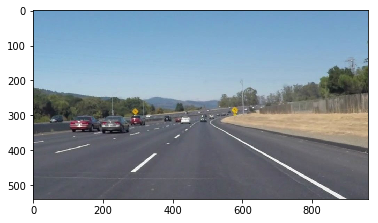

Image solidWhiteRight.jpg captured in array with dimensions:(540, 960, 3)


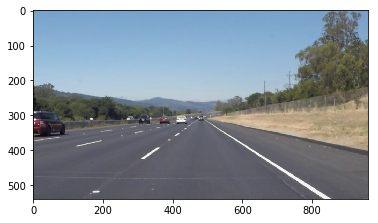

Image solidYellowCurve.jpg captured in array with dimensions:(540, 960, 3)


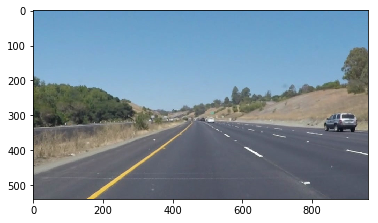

Image solidYellowCurve2.jpg captured in array with dimensions:(540, 960, 3)


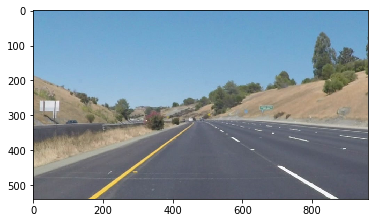

Image solidYellowLeft.jpg captured in array with dimensions:(540, 960, 3)


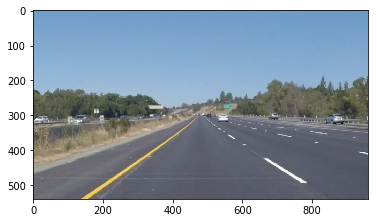

Image whiteCarLaneSwitch.jpg captured in array with dimensions:(540, 960, 3)


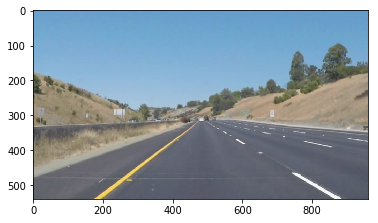

In [236]:
import os
import matplotlib.pyplot as plot
import matplotlib.image as mpImage
import numpy as np
import cv2
from IPython.display import HTML, display
%matplotlib inline

#Read and display static Images
static_image_path = os.getcwd() + '/test_images/'
static_image_path_iterator = os.listdir(static_image_path)
staticImages = []
count = 0
for static_image in static_image_path_iterator:
    staticImages.append(mpImage.imread(static_image_path + static_image))
    print('Image ' + static_image + ' captured in array with dimensions:' + str(staticImages[count].shape))
    plot.imshow(staticImages[count])
    plot.show()
    count = count + 1

#### Step 2 - Region Masking to select only the area of interest

By creating a mask which excludes image data outside the area of interest - the processing time for the rest of the pipeline should be reduced as the edge detection algorithms no longer need to work on the extra information present in the image that doesn't help with navigation.

In the code below, the variables region_point_1, region_point_2 and region_point_3 represent the points on a triangular area of interest and the boundary lines line_A, line_B and line_C representing the boundary lines of the area of interest.

The region mask area is highlighted in red in the first set of images and this is masked to show the resulting area of interest.



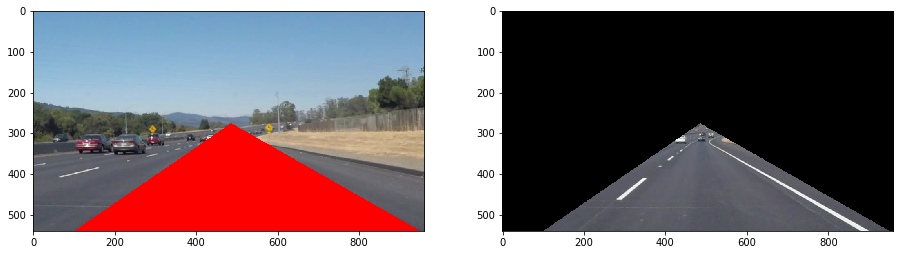

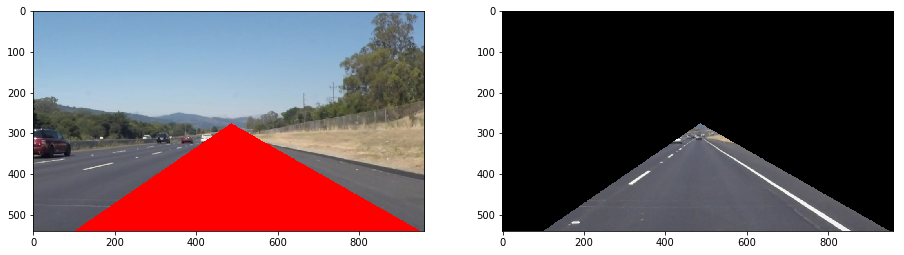

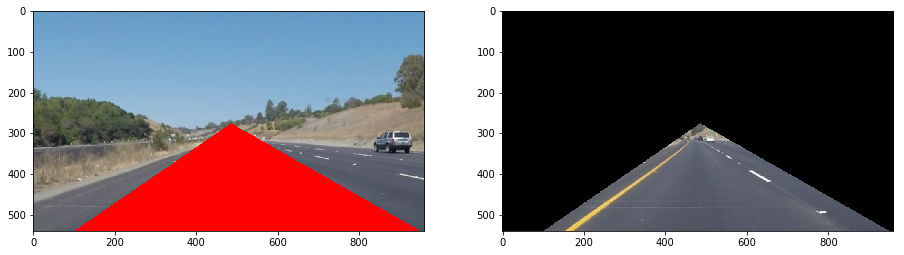

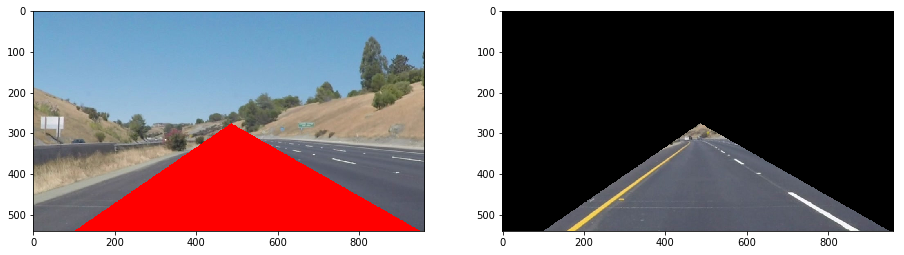

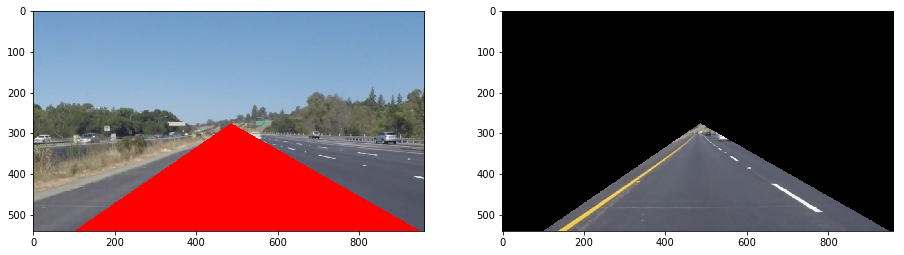

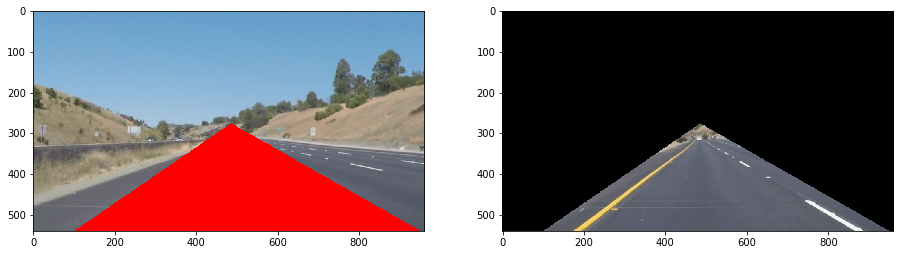

In [237]:
#Setup region of interest for images using hard coded points for now
#eventually these can be based on percentages so it scales if the image size changes
region_point_1 = [100,540] 
region_point_2 = [950,540]
region_point_3 = [485,275]
line_A = np.polyfit((region_point_3[0], region_point_1[0]), (region_point_3[1], region_point_1[1]), 1)
line_B = np.polyfit((region_point_3[0], region_point_2[0]), (region_point_3[1], region_point_2[1]), 1)
line_C = np.polyfit((region_point_1[0], region_point_2[0]), (region_point_1[1], region_point_2[1]), 1)

#now loop through and copy defined images in order to delineate the area of interest
region_masked_images = []
region_highlighted_images = []

defaultPlotX = plot.rcParams["figure.figsize"][0] 
defaultPlotY = plot.rcParams["figure.figsize"][1]
total_width_inches = (x + 150)/f.dpi
total_height_inches = (y + 50)/f.dpi
plot.rcParams["figure.figsize"][0] = total_width_inches
plot.rcParams["figure.figsize"][1] = total_height_inches


for image in staticImages:
    (y,x) = (image.shape[0],image.shape[1])
    region_masked_images.append(np.copy(image))
    region_highlighted_images.append(np.copy(image))
    (xx, yy) = np.meshgrid(np.arange(0,x),np.arange(0,y))
    area_of_interest = (yy > (xx*line_A[0]+line_A[1])) & (yy > (xx*line_B[0] + line_B[1])) & (yy < (xx*line_C[0] + line_C[1]))
    discarded_area = np.invert(area_of_interest)
    current_image_index = len(region_masked_images)-1
    region_masked_images[current_image_index][discarded_area] = [0,0,0]
    region_highlighted_images[current_image_index][area_of_interest] = [255,0,0]
    f = plot.figure()
    f.add_subplot(1,2,1)
    plot.imshow(region_highlighted_images[current_image_index])
    f.add_subplot(1,2,2)
    plot.imshow(region_masked_images[current_image_index])
    figurePixelSize = f.get_size_inches() * f.dpi
    figureInchesSize = f.get_size_inches()
    plot.show()

#### Step 3 - Finding lines in the area of interest

Now that we've limited the camera view to the field of interest, the next step is to look for lines. To do this we will use Canny Edge detection which comes in the OpenCV library. 

>Note: There are an alternative set of algorithms for edge detection are those based on the Phase-Stretch-Transform (PST) algorithm - https://en.wikipedia.org/wiki/Phase_stretch_transform 

Canny Edge detection allows this to be done in a generic way that finds line boundaries in the image without resorting to colour matching techniques. It instead finds the boundaries which define that some edge exists - whether its based on a colour difference or even a structural one.

This technique could be enhanced by splitting the pipeline and converting the images to different colour schemes. This would allow the algorithm to find lines under various visibility and lighting conditions but this won't be covered in this exercise.

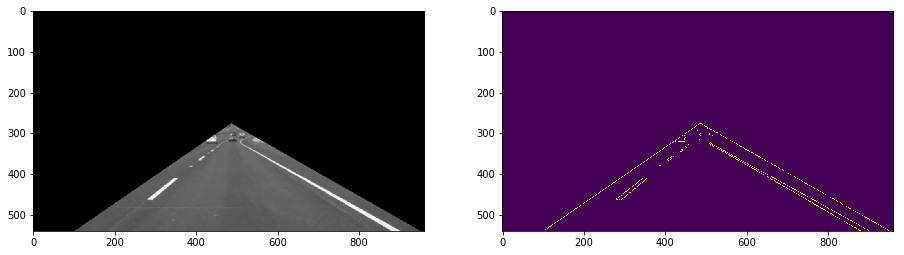

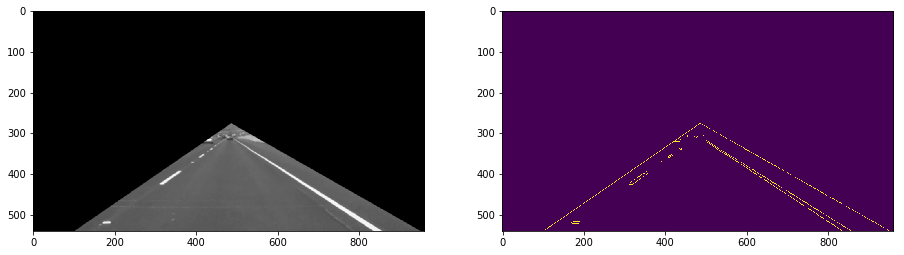

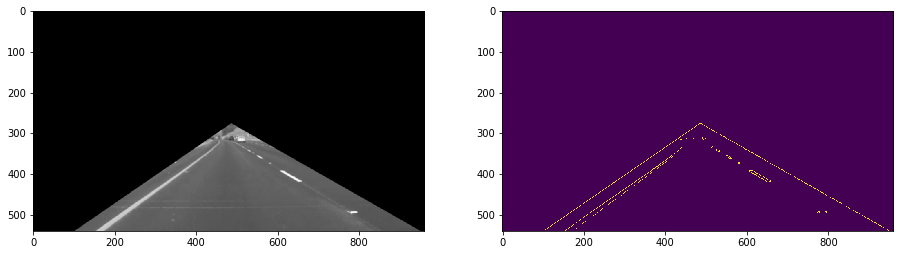

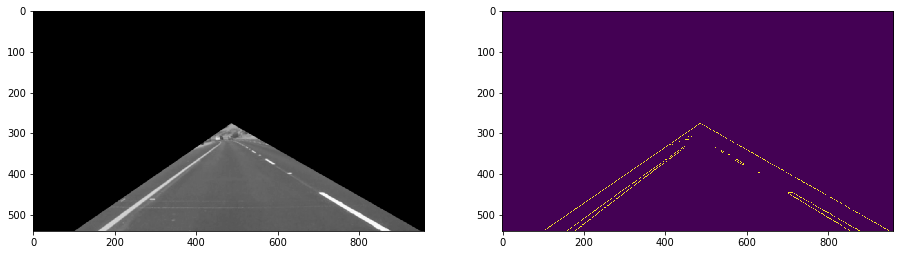

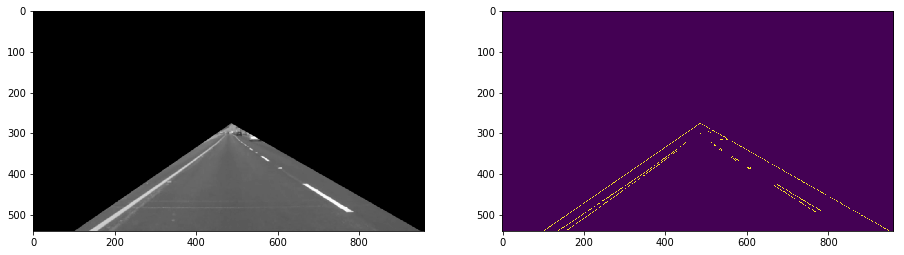

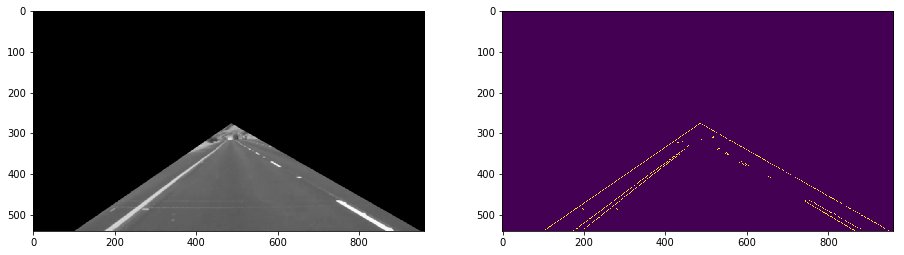

In [238]:
#plot.rcParams["figure.figsize"][0] = defaultPlotX 
#plot.rcParams["figure.figsize"][1] = defaultPlotY
plot.rcParams["figure.figsize"][0] = total_width_inches
plot.rcParams["figure.figsize"][1] = total_height_inches
canny_images = []
current_image_index = 0
low_threshold = 254
high_threshold = 255
for image in region_masked_images:
    canny_images.append(np.copy(region_masked_images[current_image_index]))
    
    f = plot.figure()
    f.add_subplot(1,2,1)
    canny_images[current_image_index] = cv2.GaussianBlur(canny_images[current_image_index],(3, 3),0)
    canny_images[current_image_index] = cv2.cvtColor(canny_images[current_image_index],cv2.COLOR_RGB2GRAY)
    plot.imshow(canny_images[current_image_index], cmap='gray')
    canny_images[current_image_index] = cv2.Canny(canny_images[current_image_index], low_threshold, high_threshold)
    f.add_subplot(1,2,2)
    plot.imshow(canny_images[current_image_index])
    plot.show()
    current_image_index = current_image_index + 1
    

### Step 4 - Run the Hough transform on the selected images

After detecting the lines in our area of interest, we can now use the Hough transform to delineate them. It will be important to first discard the lines detected at the boundary of the area of interest though - as these lines should not be considered for lane detection.

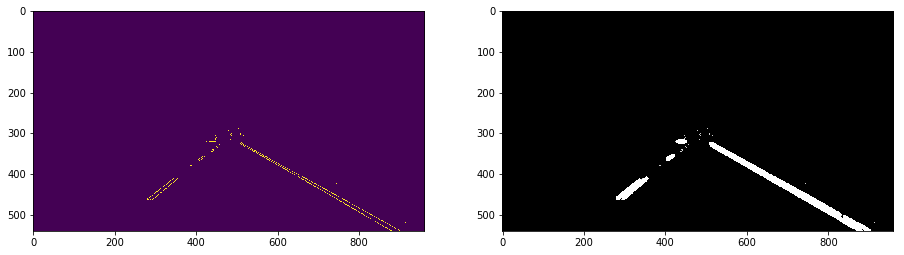

Found 27 lines using the Hough Transform.


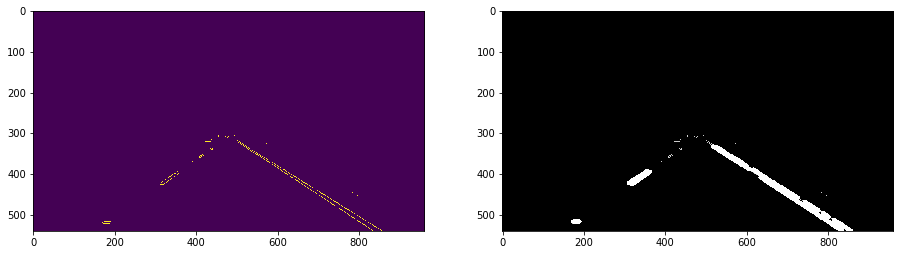

Found 27 lines using the Hough Transform.


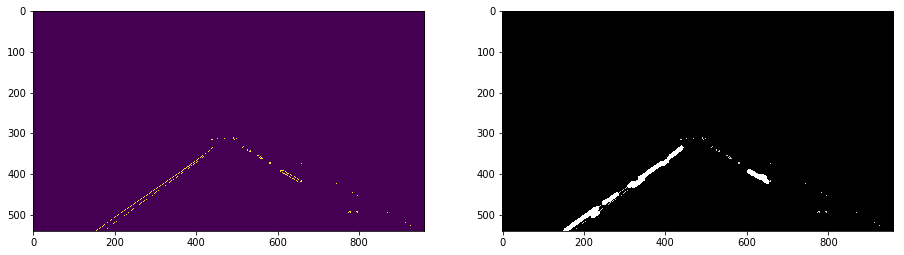

Found 27 lines using the Hough Transform.


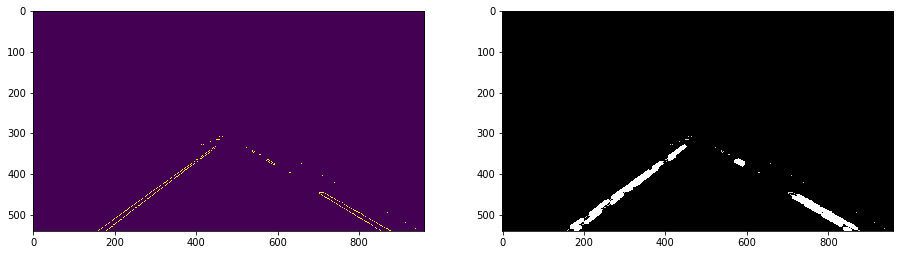

Found 27 lines using the Hough Transform.


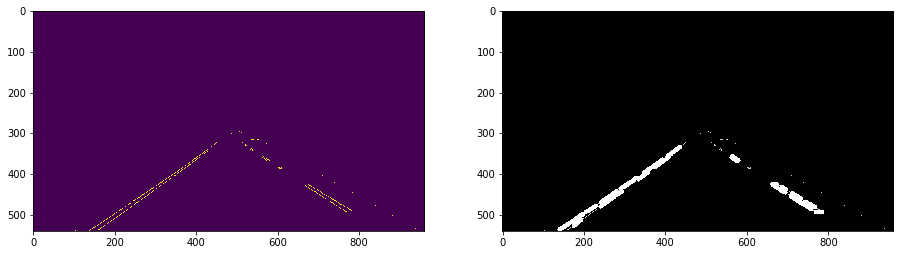

Found 27 lines using the Hough Transform.


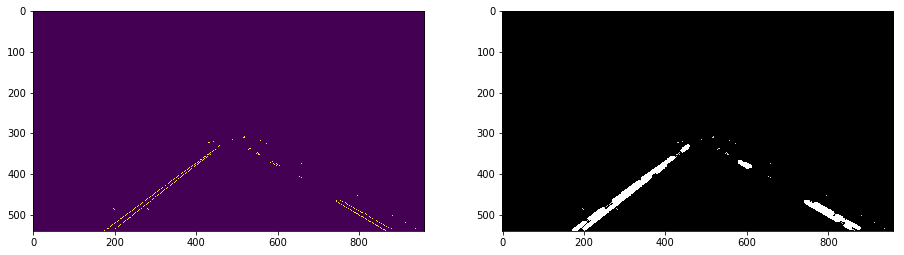

Found 27 lines using the Hough Transform.


In [239]:
#Slightly reduce the area of interest to get rid of the lines detected there - change by 1 pixels
region_point_1 = [101,540] 
region_point_2 = [949,540]
region_point_3 = [485,276]
line_A = np.polyfit((region_point_3[0], region_point_1[0]), (region_point_3[1], region_point_1[1]), 1)
line_B = np.polyfit((region_point_3[0], region_point_2[0]), (region_point_3[1], region_point_2[1]), 1)
line_C = np.polyfit((region_point_1[0], region_point_2[0]), (region_point_1[1], region_point_2[1]), 1)

current_image_index = 0
hough_images = []
hough_image_lines = []

for image in canny_images:
    hough_images.append(np.copy(image))
    (y,x) = (image.shape[0],image.shape[1])
    (xx, yy) = np.meshgrid(np.arange(0,x),np.arange(0,y))
    reduced_aoi = (yy > (xx*line_A[0]+line_A[1])) & (yy > (xx*line_B[0] + line_B[1])) & (yy < (xx*line_C[0] + line_C[1]))
    discard_area = np.invert(reduced_aoi)
    hough_images[current_image_index][discard_area] = 0
    f = plot.figure()
    f.add_subplot(1,2,1)
    plot.imshow(hough_images[current_image_index])
    
    #hough_images[current_image_index][discard_area] = hough_images[current_image_index][3]
    
    # Define Hough parameters
    rho = 1
    theta = np.pi/180
    threshold = 1
    min_line_length = 10
    max_line_gap = 1
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    hough_image_lines.append(cv2.HoughLinesP(hough_images[current_image_index], rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap))
    

    # Iterate over the output "lines" and draw lines on the blank
    for line in hough_image_lines[current_image_index]:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    line_image = np.dstack((line_image,line_image,line_image))
    color_edges = np.dstack((hough_images[current_image_index], hough_images[current_image_index], hough_images[current_image_index])) 

    # Draw the lines on the edge image
    hough_images[current_image_index] = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    f.add_subplot(1,2,2)
    plot.imshow(hough_images[current_image_index])
    plot.show()
    
    print('Found ' + str(len(lines)) + ' lines using the Hough Transform.')
    current_image_index = current_image_index + 1


### Final Step - Extrapolating lines and overlaying

Now that we have detected our lines we need to extrapolate them. Using the formula for a line: y = mx + c - we see that:
* lines which are clustered together will most likely represent that same lane line and 
* these will have an intercept which is within a certain range of each other

So to extrapolate the lines we will determine the intercepts of each line, cluster those together which have intercepts within a certain pixel range and assume that the two groups with the highest number of lines represent our lane lines.

There are alternate methods to determining one lane line from another - such as looking for positive vs negative gradients - but on its own this method isn't always guaranteed to yield desirable results. For example, in a corner or sharp bend where the camera visibility and hence the number of hough lines will decrease, or where lane lines are partially obsured, its possible for all the lines found to appear to have similar gradients.

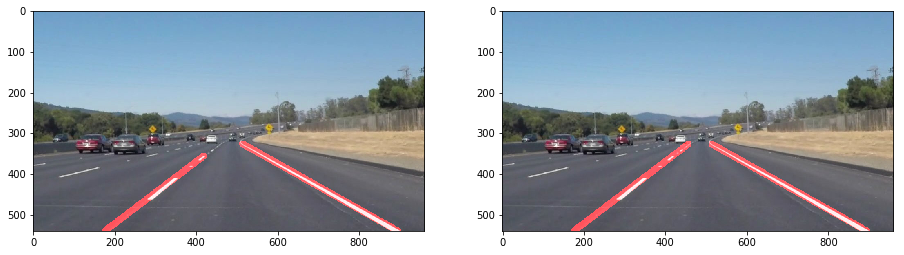

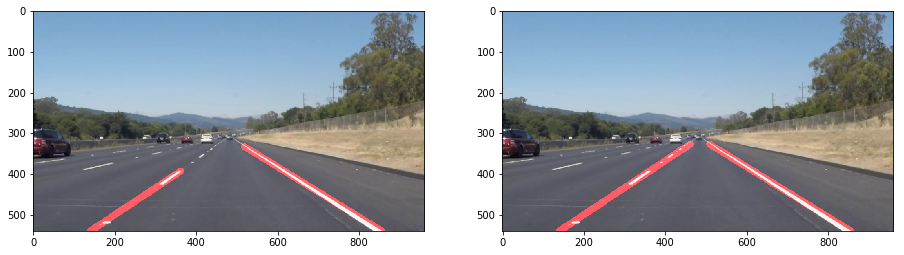

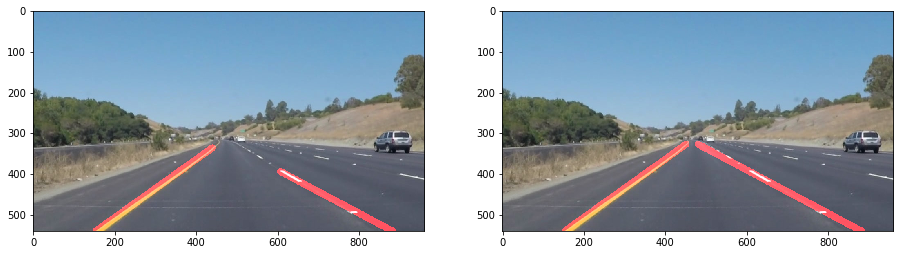

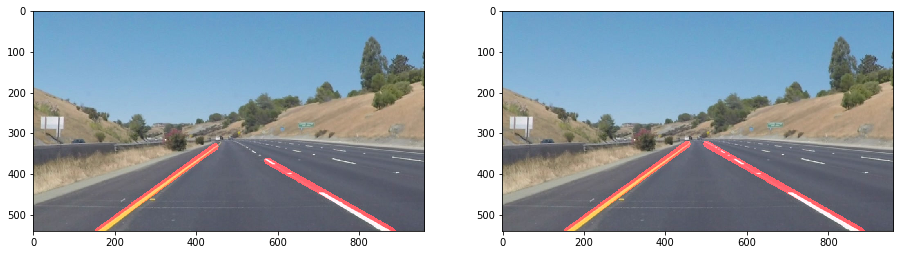

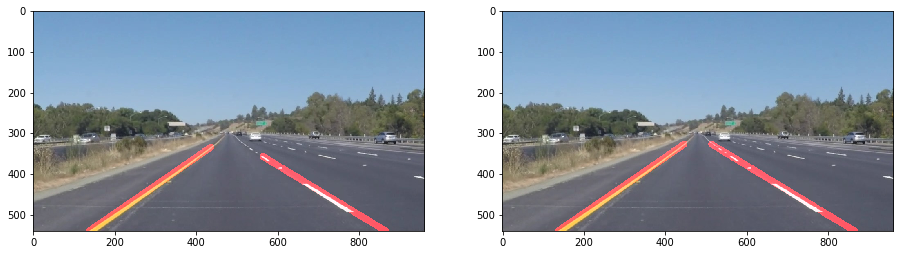

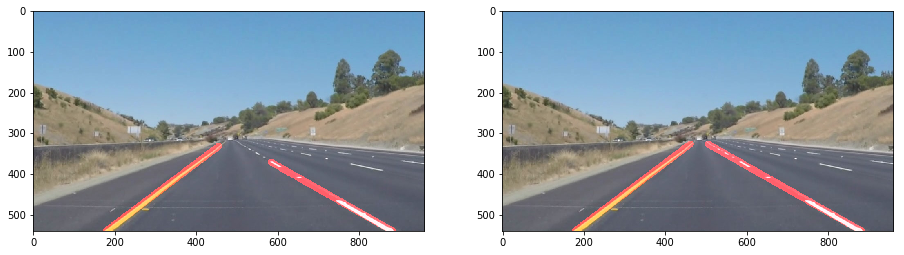

In [281]:
intercept_threshold = 100 #number of pixels to use for grouping
current_image_index = 0
final_output_images = []
for lines in hough_image_lines:
    linegroups = {}
    linegroups_lengths = {}
    linegroups_avg_max_intercept = {}
    for line in lines:
        for x1,y1,x2,y2 in line:
            #Using c = y - mx to determine the y-intercept of this line
            m = (y2-y1)/(x2-x1)
            c = y1 - (m*x1)
            #Was going to use the length to determine which lines take priority but the intercept threshold
            #seems to do a good enough job.
            #length = np.sqrt((x2-x1)**2 + (y2-y1)**2) 
            
            #Now substituting, we can find the max-intercept (i.e where y=max using the form xi = (y-c)/m )
            #since (0,0) starts in the top left. However we only want to get this when the gradient is non-zero. 
            if m > 0 or m < 0:
                max_intercept = (staticImages[current_image_index].shape[0] - c)/m #using the shape instead of 0 since
                if len(linegroups) == 0:
                    linegroups[round(max_intercept)] = []
                    linegroups[round(max_intercept)].append(line)
                    linegroups_avg_max_intercept[round(max_intercept)] = []
                    linegroups_avg_max_intercept[round(max_intercept)].append(max_intercept)
                    #linegroups_lengths[round(max_intercept)] = []
                    #linegroups_lengths[round(max_intercept)].append(length)
                else:
                    groupFound = False
                    for key in linegroups.keys():
                        if max_intercept >= key-intercept_threshold and max_intercept <= key + intercept_threshold:
                            linegroups[key].append(line)
                            linegroups_avg_max_intercept[key].append(max_intercept)
                            #linegroups_lengths[key].append(length)
                            groupFound = True
                    if groupFound == False:
                        linegroups[round(max_intercept)] = []
                        linegroups[round(max_intercept)].append(line)
                        linegroups_avg_max_intercept[round(max_intercept)] = []
                        linegroups_avg_max_intercept[round(max_intercept)].append(max_intercept)
                        #linegroups_lengths[round(x_intercept)] = []
                        #linegroups_lengths[round(x_intercept)].append(length)

    #Now we have our line groups, select the two that have the most lines clustered
    max_values = [[0,0],[0,0]]
    for key in linegroups.keys():
        if len(linegroups[key]) > max_values[1][1]:
            max_values[1] = [key, len(linegroups[key])]
        if max_values[0][1] < max_values[1][1]:
            temp = max_values[0]
            max_values[0] = max_values[1]
            max_values[1] = temp

    #These two are most likely to be the lane lines. Now we can compute an average line from each of these
    #groups and display over our lane lines
    line1_x1 = []
    line1_x2 = []
    line1_y1 = []
    line1_y2 = []
    line2_x1 = []
    line2_x2 = []
    line2_y1 = []
    line2_y2 = []

    for line in linegroups[max_values[0][0]]:
        line1_x1.append(line[0][0])
        line1_y1.append(line[0][1])
        line1_x2.append(line[0][2])
        line1_y2.append(line[0][3])
    min_l1_x = int(np.min(line1_x1 + line1_x2))
    min_l1_y = int(np.min(line1_y1 + line1_y2))
    max_l1_x = int(np.max(line1_x1 + line1_x2))
    max_l1_y = int(np.max(line1_y1 + line1_y2))
    all_l1_m = np.divide(np.subtract(line1_y2, line1_y1), np.subtract(line1_x2, line1_x1))
    average_l1_m = np.mean(np.divide(np.subtract(line1_y2, line1_y1), np.subtract(line1_x2, line1_x1)))
    average_l1_max_intercept = int(np.mean(linegroups_avg_max_intercept[max_values[0][0]]))
    
    #This is weird thinking in diverging flipped gradients
    if average_l1_m > 0:  
        l1_extrap_point = (min_l1_x, min_l1_y)
    else:
        l1_extrap_point = (max_l1_x, min_l1_y)


    for line in linegroups[max_values[1][0]]:
        line2_x1.append(line[0][0])
        line2_y1.append(line[0][1])
        line2_x2.append(line[0][2])
        line2_y2.append(line[0][3])
    min_l2_x = int(np.min(line2_x1 + line2_x2))
    min_l2_y = int(np.min(line2_y1 + line2_y2))
    max_l2_x = int(np.max(line2_x1 + line2_x2))
    max_l2_y = int(np.max(line2_y1 + line2_y2))
    average_l2_m = np.mean(np.divide(np.subtract(line2_y2, line2_y1), np.subtract(line2_x2, line2_x1)))
    average_l2_max_intercept = int(np.mean(linegroups_avg_max_intercept[max_values[1][0]]))
    if average_l2_m > 0:
        l2_extrap_point = (min_l2_x, min_l2_y)
    else:
        l2_extrap_point = (max_l2_x, min_l2_y)
        
        
    f = plot.figure()
    f.add_subplot(1,2,1)
    line_image = np.zeros_like(staticImages[current_image_index])
    cv2.line(line_image,l1_extrap_point,(average_l1_max_intercept,staticImages[current_image_index].shape[0]), (255,0,0), 15)
    cv2.line(line_image,l2_extrap_point,(average_l2_max_intercept,staticImages[current_image_index].shape[0]), (255,0,0), 15)
    plot.imshow(cv2.addWeighted(staticImages[current_image_index], 1.0, line_image,0.95,0.0))
    
    #And finally - extrapolate the lines to a point just below the apex of our area of interest 
    extrap_to_y = region_point_3[1] + 50
    
    extrap_l1_m = (staticImages[current_image_index].shape[0]-l1_extrap_point[1])/(average_l1_max_intercept-l1_extrap_point[0])
    #m = y2-y1/x2-x1 => x2-x1 = (y2-y1)/m => x1 = x2 -((y2-y1)/m)
    extrap_l1_x = int(average_l1_max_intercept - ((staticImages[current_image_index].shape[0]-extrap_to_y)/extrap_l1_m))
    l1_extrap_point = (extrap_l1_x,extrap_to_y)
    
    extrap_l2_m = (staticImages[current_image_index].shape[0]-l2_extrap_point[1])/(average_l2_max_intercept-l2_extrap_point[0])
    extrap_l2_x = int(average_l2_max_intercept - ((staticImages[current_image_index].shape[0]-extrap_to_y)/extrap_l2_m))
    l2_extrap_point = (extrap_l2_x,extrap_to_y)
    
    #And draw these lines on our original images
    line_image = np.zeros_like(staticImages[current_image_index])
    cv2.line(line_image,l1_extrap_point,(average_l1_max_intercept,staticImages[current_image_index].shape[0]), (255,0,0), 15)
    cv2.line(line_image,l2_extrap_point,(average_l2_max_intercept,staticImages[current_image_index].shape[0]), (255,0,0), 15)
    final_output_images.append(cv2.addWeighted(staticImages[current_image_index], 1.0, line_image,0.95,0.0))
    f.add_subplot(1,2,2)
    plot.imshow(final_output_images[current_image_index])
    plot.show()
    current_image_index = current_image_index + 1

### Notes for improvement

While the above images do show that the algorithms used have been effective in finding the lane lines, there are a number of optimisations which could be made to improve the performance under different lighting conditions - such as capturing additional data and using different colour palettes.

The final video output examples can be found [here](P1_Solution_Video.ipynb)